# Segmenting and Clustering Neighborhoods in Toronto

### Importing Necessary Libraries

Importing libraries that will be used to analyze the data 

In [35]:
import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt  
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans 
from geopy.geocoders import Nominatim
import requests 
!pip install folium
import folium 
from bs4 import BeautifulSoup
import seaborn as sns 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## Task 1: Create a dataframe consisting of: PostalCode, Borough, and Neighborhood

Scrapping the Wikipedia page into a BeautifulSoup object  

In [36]:
wiki_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(wiki_url, "html.parser")

Transforming the BeautifulSoup object into a pandas dataframe and eliminating observations with unassigned Boroughs

In [37]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [38]:
df.shape

(103, 3)

Text(0.5, 1.0, 'Count of Top 4 Boroughs')

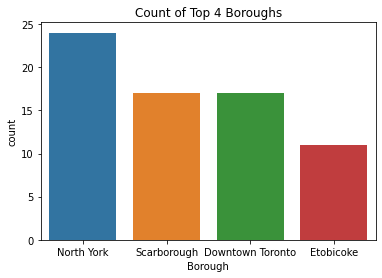

In [39]:
#Creating count bar plot of Boroughs
sns.countplot(x="Borough", data=df,
              order=df.Borough.value_counts().iloc[0:4].index).set_title("Count of Top 4 Boroughs")

## Task 2: Obtain latitude and longitude coordinates of each neighborhood

In [40]:
df_coordinates = pd.read_csv('https://cocl.us/Geospatial_data')

Confirming that both datasets have the same shape

In [41]:
print("Shape of wiki Dataset is: ", df.shape)
print("Shape of wiki Dataset is: ", df_coordinates.shape)

Shape of wiki Dataset is:  (103, 3)
Shape of wiki Dataset is:  (103, 3)


Merging the two datasets so that the geographical coordinates are included

In [42]:
merged_data = pd.merge(df, df_coordinates, left_on='Postal Code', right_on='Postal Code')
merged_data

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [43]:
print('There are {} uniques categories.'.format(len(merged_data['Borough'].unique())))

There are 15 uniques categories.


In [44]:
print('There are {} uniques categories.'.format(len(merged_data['Neighborhood'].unique())))

There are 103 uniques categories.


## Task 3: Clustering Neighborhoods and Creating a Map of Toronto

Finding Toronto's geographical coordinates

In [45]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Creating a map of Toronto given the obtained coordinates 

In [46]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for latitude, longitude, borough, neighborhood in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Borough'], merged_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True
        ).add_to(map_Toronto)  
    
map_Toronto

Including foursquare details 

In [47]:
Client_ID = 'RX5TLLGY4MYIJP3XZT34VNBNSS0TN5AXFG0SNC0FGIMRTSEU' 
Client_Secret = 'JWILM1FOAB3LCXXJ4ZSM4T0USJFC3SLJSY5VSJ4FXIHPOPIE' 
Version = '20210804'

LIMIT = 200
radius = 500

Defining a function to get the venues of each neighborhood

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_ID, 
            Client_Secret, 
            Version, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Collecting the venues and creating a new dataframe 

In [49]:
venues_Toronto = getNearbyVenues(names=merged_data['Neighborhood'],
                                   latitudes=merged_data['Latitude'],
                                   longitudes=merged_data['Longitude']
                                  )

In [50]:
venues_Toronto.shape

(2111, 7)

In [51]:
venues_Toronto.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [52]:
venues_Toronto.groupby('Neighborhood').head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...
2096,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,South St. Burger,43.631314,-79.518408,Burger Joint
2097,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Wingporium,43.630275,-79.518169,Wings Joint
2098,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Dollarama,43.629883,-79.518627,Discount Store
2099,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Healthy Planet,43.630214,-79.518495,Supplement Shop


In [53]:
venues_Toronto.groupby('Venue Category').max()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Ardene Shoes Outlet,43.718892,-79.461344
Adult Boutique,Church and Wellesley,43.665860,-79.383160,Seduction,43.665620,-79.384681
Airport,Downsview East,43.737473,-79.394420,Toronto Downsview Airport (YZD),43.738883,-79.396033
Airport Food Court,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,Billy Bishop Café,43.631132,-79.396139
Airport Gate,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,Gate 8,43.631536,-79.394570
...,...,...,...,...,...,...
Warehouse Store,Thorncliffe Park,43.705369,-79.349372,Costco,43.707051,-79.348093
Wine Bar,"Toronto Dominion Centre, Design Exchange",43.657952,-79.375418,The National Club,43.659128,-79.380574
Wings Joint,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Wingporium,43.630275,-79.518169


In [54]:
print('There are {} uniques categories.'.format(len(venues_Toronto['Venue Category'].unique())))

There are 269 uniques categories.


Hot Encoding Venue Categories

In [55]:
venue_Toronto_cat = pd.get_dummies(venues_Toronto[['Venue Category']], prefix="", prefix_sep="")
venue_Toronto_cat

,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding in Neighborhood to the hot encoded dataframe

In [56]:
venue_Toronto_cat['Neighborhood'] = venues_Toronto['Neighborhood'] 

# moving neighborhood column to the first column
fixed_columns = [venue_Toronto_cat.columns[-1]] + list(venue_Toronto_cat.columns[:-1])
venue_Toronto_cat = venue_Toronto_cat[fixed_columns]

venue_Toronto_cat.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping by Neighborhood and Calculating the Venue Means

In [57]:
neighborhood_Toronto = venue_Toronto_cat.groupby('Neighborhood').mean().reset_index()
neighborhood_Toronto

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Willowdale South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0
94,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
95,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
96,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [58]:
neighborhood_Toronto.shape

(98, 269)

Finding Most Common Venue by Neighborhoods

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [61]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_Toronto['Neighborhood']

for ind in np.arange(neighborhood_Toronto.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_Toronto.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Pub,Sandwich Place,Gym,Airport Gate,Event Space,Escape Room,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pizza Place,Supermarket,Deli / Bodega,Sushi Restaurant,Middle Eastern Restaurant,Ice Cream Shop,Shopping Mall,Mobile Phone Shop
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Women's Store,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Liquor Store,Pharmacy,Pub,Butcher,Café,Sushi Restaurant


Using KMeans to Cluster Neighborhoods

In [62]:
# Setting number of clusters
k_num_clusters = 5
neighborhood_Toronto_clustering = neighborhood_Toronto.drop('Neighborhood', 1)

# Running k-means clustering
kmeans = KMeans(n_clusters=k_num_clusters, random_state=0).fit(neighborhood_Toronto_clustering)
kmeans

# Checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int32)

Creating new dataframe with cluster labels

In [63]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged_venues = merged_data
Toronto_merged_venues = Toronto_merged_venues.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged_venues.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,Park,Food & Drink Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Financial or Legal Service,Portuguese Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Gym / Fitness Center,Event Space,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Furniture / Home Store,Clothing Store,Accessories Store,Vietnamese Restaurant,Miscellaneous Shop,Boutique,Coffee Shop,Dog Run,Dim Sum Restaurant,Diner
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Italian Restaurant,Japanese Restaurant,Beer Bar,Smoothie Shop,Sandwich Place


Eliminating any potential Nan Values

In [64]:
Toronto_merged_nonan = Toronto_merged_venues.dropna(subset=['Cluster Labels'])

Plotting Map Clusters

In [65]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_nonan['Latitude'], Toronto_merged_nonan['Longitude'], Toronto_merged_nonan['Neighborhood'], Toronto_merged_nonan['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(map_clusters)
        
map_clusters

Visualizing the clusters

In [66]:
TCluster_0 = Toronto_merged_nonan.loc[Toronto_merged_nonan['Cluster Labels'] == 0, Toronto_merged_nonan.columns[[1] + list(range(5, Toronto_merged_nonan.shape[1]))]]
TCluster_0

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0.0,Financial or Legal Service,Portuguese Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,Downtown Toronto,0.0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Gym / Fitness Center,Event Space,Restaurant
3,North York,0.0,Furniture / Home Store,Clothing Store,Accessories Store,Vietnamese Restaurant,Miscellaneous Shop,Boutique,Coffee Shop,Dog Run,Dim Sum Restaurant,Diner
4,Queen's Park,0.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Italian Restaurant,Japanese Restaurant,Beer Bar,Smoothie Shop,Sandwich Place
6,Scarborough,0.0,Fast Food Restaurant,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
...,...,...,...,...,...,...,...,...,...,...,...,...
96,Downtown Toronto,0.0,Coffee Shop,Café,Restaurant,Pizza Place,Chinese Restaurant,Italian Restaurant,Pub,Bakery,Butcher,Playground
97,Downtown Toronto,0.0,Coffee Shop,Café,Hotel,Japanese Restaurant,Gym,Restaurant,Steakhouse,Seafood Restaurant,Asian Restaurant,Salad Place
99,Downtown Toronto,0.0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Yoga Studio,Fast Food Restaurant,Pub,Hotel,Mediterranean Restaurant
100,East Toronto Business,0.0,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place,Butcher


In [67]:
TCluster_1 = Toronto_merged_nonan.loc[Toronto_merged_nonan['Cluster Labels'] == 1, Toronto_merged_nonan.columns[[1] + list(range(5, Toronto_merged_nonan.shape[1]))]]
TCluster_1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,1.0,Baseball Field,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store,Farmers Market
101,Etobicoke,1.0,Baseball Field,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store,Farmers Market


In [68]:
TCluster_2 = Toronto_merged_nonan.loc[Toronto_merged_nonan['Cluster Labels'] == 2, Toronto_merged_nonan.columns[[1] + list(range(5, Toronto_merged_nonan.shape[1]))]]
TCluster_2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Scarborough,2.0,Motel,American Restaurant,Women's Store,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


In [69]:
TCluster_3 = Toronto_merged_nonan.loc[Toronto_merged_nonan['Cluster Labels'] == 3, Toronto_merged_nonan.columns[[1] + list(range(5, Toronto_merged_nonan.shape[1]))]]
TCluster_3

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,3.0,Park,Food & Drink Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space
21,York,3.0,Park,Pool,Women's Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Escape Room,Deli / Bodega
35,East York/East Toronto,3.0,Park,Intersection,Convenience Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dessert Shop,Donut Shop
40,North York,3.0,Park,Airport,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
61,Central Toronto,3.0,Park,Bus Line,Swim School,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Department Store
66,North York,3.0,Park,Convenience Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Deli / Bodega
85,Scarborough,3.0,Park,Intersection,Playground,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
91,Downtown Toronto,3.0,Park,Trail,Playground,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
98,Etobicoke,3.0,River,Park,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


In [70]:
TCluster_4 = Toronto_merged_nonan.loc[Toronto_merged_nonan['Cluster Labels'] == 4, Toronto_merged_nonan.columns[[1] + list(range(5, Toronto_merged_nonan.shape[1]))]]
TCluster_4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
83,Central Toronto,4.0,Restaurant,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega


## Filtering Venues to Restaurants

 Filtering Data to Only Restaurants

In [71]:
venues_Toronto.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [72]:
venues_Toronto['Venue Category'].unique()

array(['Park', 'Food & Drink Shop', 'Hockey Arena',
       'Portuguese Restaurant', 'Coffee Shop', 'Pizza Place',
       'Financial or Legal Service', 'Bakery', 'Distribution Center',
       'Spa', 'Restaurant', 'Breakfast Spot', 'Gym / Fitness Center',
       'Historic Site', 'Chocolate Shop', 'Farmers Market', 'Pub',
       'Performing Arts Venue', 'French Restaurant', 'Dessert Shop',
       'Yoga Studio', 'Café', 'Theater', 'Mexican Restaurant',
       'Event Space', 'Shoe Store', 'Art Gallery', 'Brewery',
       'Cosmetics Shop', 'Electronics Store', 'Bank', 'Beer Store',
       'Hotel', 'Antique Shop', 'Boutique', 'Furniture / Home Store',
       'Vietnamese Restaurant', 'Clothing Store', 'Accessories Store',
       'Miscellaneous Shop', 'Italian Restaurant', 'Creperie', 'Beer Bar',
       'Sushi Restaurant', 'Burrito Place', 'Diner', 'Discount Store',
       'Fried Chicken Joint', 'Japanese Restaurant', 'Smoothie Shop',
       'Sandwich Place', 'Gym', 'Bar', 'College Auditorium',

Venues are mainly comprised of different restaurants which will be what we investigate

In [73]:
Venues_Restaurants = ['Neighborhood',
                      'Fast Food Restaurant', 
                      'Food & Drink Shop', 
                      'Portuguese Restaurant',
                      'Pizza Place',
                      'Restaurant', 
                      'Breakfast Spot',
                      'French Restaurant',
                      'Vietnamese Restaurant',
                      'Italian Restaurant',
                      'Sushi Restaurant',
                      'Burrito Place',
                      'Mexican Restaurant',
                      'Diner',
                      'Fried Chicken Joint', 
                      'Japanese Restaurant',
                      'Sandwich Place',
                      'Vegetarian / Vegan Restaurant',
                      'Caribbean Restaurant',
                      'Ramen Restaurant',
                      'Middle Eastern Restaurant',
                      'Steakhouse', 
                      'Burger Joint',
                      'Thai Restaurant',  
                      'Modern European Restaurant',
                      'New American Restaurant',
                      'Ethiopian Restaurant', 
                      'Seafood Restaurant', 
                      'Chinese Restaurant',
                      'Dim Sum Restaurant', 
                      'Asian Restaurant',
                      'BBQ Joint', 
                      'American Restaurant',
                      'German Restaurant',
                      'Comfort Food Restaurant', 
                      'Moroccan Restaurant', 
                      'Bistro', 
                      'Belgian Restaurant', 
                      'Greek Restaurant',
                      'Eastern European Restaurant',
                      'Indian Restaurant',
                      'Korean BBQ Restaurant',
                      'Poke Place',
                      'Falafel Restaurant',
                      'Salad Place', 
                      'Korean Restaurant', 
                      'Hakka Restaurant',
                      'Mediterranean Restaurant',
                      'Colombian Restaurant',
                      'Brazilian Restaurant', 
                      'Noodle House', 
                      'Gluten-free Restaurant',
                      'Latin American Restaurant',
                      'Cuban Restaurant',
                      'Tibetan Restaurant',
                      'Taco Place',
                      'Molecular Gastronomy Restaurant',
                      'Cajun / Creole Restaurant',
                      'Dumpling Restaurant', 
                      'Doner Restaurant', 
                      'Filipino Restaurant',
                      'Bed & Breakfast',
                      'Taiwanese Restaurant', 
                      'Theme Restaurant',
                      'Wings Joint']
                      

In [74]:
venues_Toronto.groupby('Neighborhood').count() #100 Observations 

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
Willowdale South,33,33,33,33,33,33
Willowdale West,5,5,5,5,5,5
Woburn,5,5,5,5,5,5


In [75]:
# one hot encoding
Venues_Encoded = pd.get_dummies(venues_Toronto[['Venue Category']], prefix="", prefix_sep="")

#column lists before adding neighborhood
column_names = ['Neighborhood'] + list(Venues_Encoded.columns)

# add neighborhood column back to dataframe
Venues_Encoded['Neighborhood'] = venues_Toronto['Neighborhood'] 

# move neighborhood column to the first column
Venues_Encoded = Venues_Encoded[column_names]

Venues_Encoded.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Neighborhood Clusters

In [76]:
col_names = []
col_names = Venues_Restaurants
Toronto_Venues_Rest = Venues_Encoded[col_names]
Toronto_Venues_Rest = Toronto_Venues_Rest.iloc[:,1::]

In [77]:
Venues_Encoded_Grouped =Toronto_Venues_Rest.groupby('Neighborhood').sum().reset_index()
Venues_Encoded_Grouped['Total'] = Venues_Encoded_Grouped.sum(axis=1)
Venues_Grouped_Clustering = Venues_Encoded_Grouped.drop('Neighborhood', 1)

In [78]:
from sklearn.metrics import silhouette_score

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(Venues_Grouped_Clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(Venues_Grouped_Clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.7244763858438001
For n_clusters=3, The Silhouette Coefficient is 0.6099089526000726
For n_clusters=4, The Silhouette Coefficient is 0.5247198774942157
For n_clusters=5, The Silhouette Coefficient is 0.5269345881108605
For n_clusters=6, The Silhouette Coefficient is 0.5167511100569303
For n_clusters=7, The Silhouette Coefficient is 0.4491962015721038
For n_clusters=8, The Silhouette Coefficient is 0.4435289262238617
For n_clusters=9, The Silhouette Coefficient is 0.4366609466012446


N=2 has the highest silhoutte coefficient at 0.7244763858438001 so we will use 2 clusters 

In [88]:
k_clusters = 2 

# Running k-means clustering
kmeans_rest = KMeans(n_clusters=k_clusters, random_state=0).fit(Venues_Grouped_Clustering)
kmeans_rest

# Checking cluster labels generated for each row in the dataframe
kmeans_rest.labels_[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [89]:
Venues_Clusters = pd.DataFrame(kmeans_rest.cluster_centers_)
Venues_Clusters.columns = Venues_Grouped_Clustering.columns
Venues_Clusters.index = ['cluster0','cluster1']
Venues_Clusters ['Total Sum'] = Venues_Clusters.sum(axis = 1)
Venues_Clusters 

,Fast Food Restaurant,Food & Drink Shop,Portuguese Restaurant,Pizza Place,Restaurant,Breakfast Spot,French Restaurant,Vietnamese Restaurant,Italian Restaurant,Sushi Restaurant,...,Cajun / Creole Restaurant,Dumpling Restaurant,Doner Restaurant,Filipino Restaurant,Bed & Breakfast,Taiwanese Restaurant,Theme Restaurant,Wings Joint,Total,Total Sum
cluster0,0.253012,0.024096,0.024096,0.397590,0.325301,0.132530,0.036145,0.048193,0.192771,0.144578,...,1.204819e-02,-1.040834e-17,-1.040834e-17,-1.040834e-17,-1.040834e-17,1.204819e-02,-1.040834e-17,1.204819e-02,3.349398,6.698795
cluster1,0.600000,0.133333,0.133333,1.266667,2.400000,0.666667,0.466667,0.400000,1.933333,1.000000,...,-1.734723e-18,6.666667e-02,6.666667e-02,6.666667e-02,6.666667e-02,-1.734723e-18,6.666667e-02,-1.734723e-18,27.400000,54.800000


Cluster1 has a higher sum and total sum at 27.4 and 54.8 versus Cluster0's 3.35 and 6.7 indicating it is more saturated 

In [90]:
Venues_Results = pd.DataFrame(Venues_Encoded_Grouped['Neighborhood'],)
Venues_Results['Total'] = Venues_Encoded_Grouped['Total']
Venues_Results = Venues_Results.assign(Cluster_Labels = kmeans_rest.labels_)
Venues_Results

,Neighborhood,Total,Cluster_Labels
0,Agincourt,2,0
1,"Alderwood, Long Branch",3,0
2,"Bathurst Manor, Wilson Heights, Downsview North",7,0
3,Bayview Village,2,0
4,"Bedford Park, Lawrence Manor East",14,0
...,...,...,...
93,Willowdale South,13,0
94,Willowdale West,1,0
95,Woburn,2,0
96,Woodbine Heights,0,0


Merging with Old Dataset to Include Postal Code and Borough Information

In [82]:
Venues_Results_Merged = merged_data
Venues_Results_Merged  = Venues_Results_Merged.join(Venues_Results.set_index('Neighborhood'), on='Neighborhood')
print(Venues_Results_Merged.shape)
Venues_Results_Merged.head(10)

(103, 7)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,5.0,0.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,0.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10.0,0.0
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,NaN,NaN
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1.0,0.0
7,M3B,North York,Don Mills North,43.745906,-79.352188,2.0,0.0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,2.0,0.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,30.0,1.0


Removing Nan Values

In [83]:
Venues_Results_Merged = Venues_Results_Merged.dropna(subset=['Cluster_Labels'])

In [84]:
print(Venues_Results_Merged.shape) #3 Observations that had Nan values were removed
Venues_Results_Merged.head(10)

(98, 7)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,5.0,0.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,0.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,10.0,0.0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1.0,0.0
7,M3B,North York,Don Mills North,43.745906,-79.352188,2.0,0.0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,2.0,0.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,30.0,1.0
10,M6B,North York,Glencairn,43.709577,-79.445073,2.0,0.0


Visualizing the Restaurant Clusters

In [85]:
Map_Toronto_Restaurants = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for latitude, longitude, borough, neighborhood in zip(Venues_Results_Merged['Latitude'], Venues_Results_Merged['Longitude'], Venues_Results_Merged['Borough'], Venues_Results_Merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True
        ).add_to(Map_Toronto_Restaurants)  
    
Map_Toronto_Restaurants

## Clustering the Neighborhoods

### Unsaturated Market 

In [91]:
ResturantCluster_0 = Venues_Results_Merged[Venues_Results_Merged['Total'] == 0].reset_index(drop=True)
ResturantCluster_0 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,0.0,0.0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,0.0
2,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.0,0.0
3,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,0.0,0.0
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.0,0.0
5,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,0.0,0.0
6,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.0,0.0
7,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,0.0,0.0
8,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0.0,0.0
9,M3K,North York,Downsview East,43.737473,-79.464763,0.0,0.0


### Saturated Market

In [92]:
ResturantCluster_1 = Venues_Results_Merged[Venues_Results_Merged['Cluster_Labels'] == 1].reset_index(drop=True)
ResturantCluster_1

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,30.0,1.0
1,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,27.0,1.0
2,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,16.0,1.0
3,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,26.0,1.0
4,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,38.0,1.0
5,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,24.0,1.0
6,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,18.0,1.0
7,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,17.0,1.0
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,38.0,1.0
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,37.0,1.0
